# Download dataset

In [1]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="C0XAEXYeZ6d5uRXrFr1g")
project = rf.workspace("truong-a6rzc").project("bien-bao-giao-thong-viet-nam-zalo")
version = project.version(1)
dataset = version.download("folder")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 63.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.17.1 which is incompatible.
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to bien-bao-giao-thong-viet-nam-zalo-1 in folder:: 100%|██████████| 4396/4396 [00:00<00:00, 6663.00it/s]


# Import libraries

In [2]:
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image
import pandas as pd
import os

In [3]:
# set torch device to available device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
torch.device(device)

Using cuda device


device(type='cuda')

# Data preprocessing

## Split dataset into format:
```dataset/
    train/
        class_1/
            image1.jpg
            ...
        class_2/
            ...
    val/
        class_1/
            ...
        class_2/
            ...
    test/
        class_1/
            ...
        class_2/
            ...

            

In [4]:
import os
import shutil
import random
from pathlib import Path

def split_dataset(dataset_dir, output_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
    random.seed(seed)

    dataset_dir = Path(dataset_dir)
    output_dir = Path(output_dir)
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1."

    for class_dir in dataset_dir.iterdir():
        if not class_dir.is_dir():
            continue
        images = list(class_dir.glob("*.*"))  # Match all image files
        random.shuffle(images)

        total = len(images)
        train_end = int(total * train_ratio)
        val_end = train_end + int(total * val_ratio)

        subsets = {
            'train': images[:train_end],
            'val': images[train_end:val_end],
            'test': images[val_end:]
        }

        for subset, subset_images in subsets.items():
            subset_class_dir = output_dir / subset / class_dir.name
            subset_class_dir.mkdir(parents=True, exist_ok=True)
            for img_path in subset_images:
                shutil.copy(img_path, subset_class_dir / img_path.name)

    print(f"Dataset split completed and saved to {output_dir}")


split_dataset("/kaggle/working/bien-bao-giao-thong-viet-nam-zalo-1/train", "/kaggle/working/dataset", train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)


Dataset split completed and saved to /kaggle/working/dataset


## Augment training set and resize images to 224x224 pixels

In [5]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ImageNet mean and std
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Augmentations for training set
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ResNet
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


# Load datasets
train_dataset = datasets.ImageFolder("/kaggle/working/dataset/train", transform=train_transform)
val_dataset = datasets.ImageFolder("/kaggle/working/dataset/val", transform=val_test_transform)
test_dataset = datasets.ImageFolder("/kaggle/working/dataset/test", transform=val_test_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)


# Visualize a sample of each set

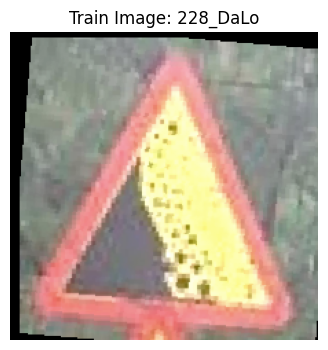

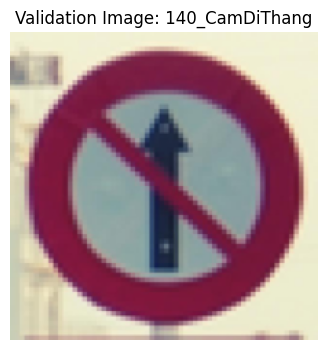

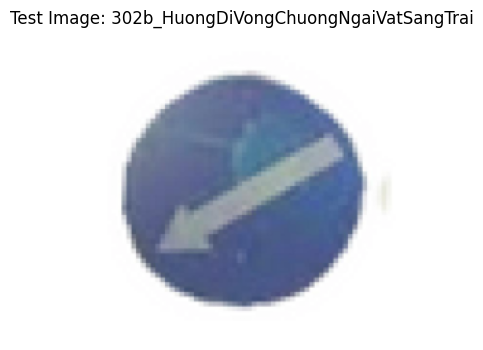

In [6]:
import random
import matplotlib.pyplot as plt
import numpy as np

def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    return img

def show_random_image(dataset, mean, std, title=''):
    idx = random.randint(0, len(dataset) - 1)
    img, label = dataset[idx]
    img = unnormalize(img, mean, std).permute(1, 2, 0).numpy()
    label_name = dataset.classes[label]

    plt.figure(figsize=(4, 4))
    plt.imshow(np.clip(img, 0, 1))
    plt.title(f"{title}: {label_name}")
    plt.axis('off')
    plt.show()

show_random_image(train_dataset, mean, std, title="Train Image")
show_random_image(val_dataset, mean, std, title="Validation Image")
show_random_image(test_dataset, mean, std, title="Test Image")


## Check number of labels in the dataset

In [7]:
len(train_dataset.classes), len(val_dataset.classes), len(test_dataset.classes)

(121, 121, 121)

# Build a CNN model

## Define optimizer, loss function, scheduler

In [8]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim

# Load pre-trained ResNet-18 model with the 'weights' argument
from torchvision.models import ResNet18_Weights  # Import the weights enumeration
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)  # Using IMAGENET1K_V1 weights

# Modify the final fully connected layer to match the number of classes
num_classes = len(train_dataset.classes)  # Update this to the number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Unfreeze all layers of ResNet
for param in model.parameters():
    param.requires_grad = True  # Unfreeze all layers

# Move the model to the correct device (GPU if available, otherwise CPU)
model = model.to(device)

# Create optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
loss_fn = nn.CrossEntropyLoss()

# Create scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 167MB/s] 


# Training

## Train, evaluation loop

In [9]:
def train(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    training_loss = []
    validation_loss = []

    for epoch in range(epochs):
        train_loss = 0.0
        val_loss = 0.0

        # model training
        model.train()

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            # zero grad
            optimizer.zero_grad()

            # forward pass
            output = model(images)
            loss = loss_fn(output, labels)

            # backward pass
            loss.backward()
            optimizer.step()

            # total loss
            train_loss += loss.item()

        # model evaluation
        model.eval()

        # using no_grad / inference
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)  # Move data to GPU
                output = model(images)
                loss = loss_fn(output, labels)
                val_loss += loss.item()

        train_loss /= len(train_loader)  # calculate avg loss
        val_loss /= len(val_loader)  # calculate avg loss

        # append data
        training_loss.append(train_loss)
        validation_loss.append(val_loss)

        # print loss per epoch
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f} - Validation Loss: {val_loss:.4f}")

        # Step the scheduler if defined
        if scheduler:
            scheduler.step(val_loss)

    return training_loss, validation_loss

## Train!!!

In [10]:
training_loss, validation_loss = train(model, train_loader, val_loader, optimizer, loss_fn, scheduler, epochs=20)

Epoch 1/20 - Training Loss: 2.6209 - Validation Loss: 0.7998
Epoch 2/20 - Training Loss: 0.6166 - Validation Loss: 0.2589
Epoch 3/20 - Training Loss: 0.2878 - Validation Loss: 0.1646
Epoch 4/20 - Training Loss: 0.2093 - Validation Loss: 0.1441
Epoch 5/20 - Training Loss: 0.1772 - Validation Loss: 0.1341
Epoch 6/20 - Training Loss: 0.1622 - Validation Loss: 0.1154
Epoch 7/20 - Training Loss: 0.1556 - Validation Loss: 0.1169
Epoch 8/20 - Training Loss: 0.1449 - Validation Loss: 0.1057
Epoch 9/20 - Training Loss: 0.1399 - Validation Loss: 0.1024
Epoch 10/20 - Training Loss: 0.1364 - Validation Loss: 0.1157
Epoch 11/20 - Training Loss: 0.1304 - Validation Loss: 0.1109
Epoch 12/20 - Training Loss: 0.1302 - Validation Loss: 0.1104
Epoch 13/20 - Training Loss: 0.1187 - Validation Loss: 0.1009
Epoch 14/20 - Training Loss: 0.1134 - Validation Loss: 0.0998
Epoch 15/20 - Training Loss: 0.1151 - Validation Loss: 0.1000
Epoch 16/20 - Training Loss: 0.1124 - Validation Loss: 0.0995
Epoch 17/20 - Tra

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np

# true_labels: ground truth labels
# predicted_labels: model predictions
cm = confusion_matrix(test_labels, predicted_labels)
misclassifications = []
for i in range(len(cm)):
    misclassified_count = cm[i].sum() - cm[i, i]  # Total predicted minus correct predictions
    misclassifications.append((i, misclassified_count))
# Sort misclassifications in descending order and take top 5
misclassifications.sort(key=lambda x: x[1], reverse=True)
top_5_misclassified = misclassifications[:5]

for class_id, count in top_5_misclassified:
    print(f"Class {class_id}: {count} misclassifications")



Class 4: 4 misclassifications
Class 107: 4 misclassifications
Class 110: 4 misclassifications
Class 26: 3 misclassifications
Class 52: 3 misclassifications


## Plot training and validation loss

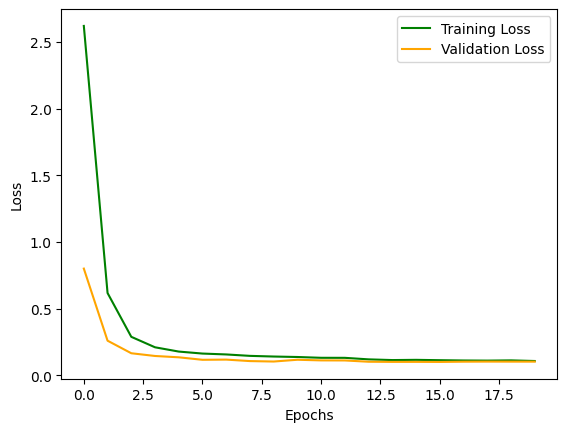

In [11]:
# visualize loss
plt.plot(training_loss, label='Training Loss', color='green')
plt.plot(validation_loss, label='Validation Loss',color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# Evaluate

## Predict on test set

In [12]:
def predict(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Ensure model is on the same device as the data

    model.eval()
    test_labels = []
    predicted_labels = []

    with torch.no_grad():  # Use torch.no_grad() for inference to save memory
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Move data to GPU

            output = model(images)
            _, predicted = torch.max(output, 1)  # Get the index of the max log-probability

            test_labels.extend(labels.cpu().numpy())  # Move labels to CPU and convert to numpy array
            predicted_labels.extend(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy array

    return test_labels, predicted_labels

In [13]:
# test model
test_labels, predicted_labels = predict(model, test_loader)

## Evaluation metrics

In [14]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, precision_score, recall_score

# print accuracy , f1score ,precision scre ,recall score
print("Accuracy:", accuracy_score(test_labels, predicted_labels))
print("F1 Score:", f1_score(test_labels, predicted_labels, average='weighted'))
print("Precision:", precision_score(test_labels, predicted_labels, average='weighted'))
print("Recall:", recall_score(test_labels, predicted_labels, average='weighted'))

# print classification report
print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

Accuracy: 0.8982725527831094
F1 Score: 0.8902186318693037
Precision: 0.8927748834658624
Recall: 0.8982725527831094
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         4
           3       0.50      0.80      0.62         5
           4       0.50      0.20      0.29         5
           5       1.00      1.00      1.00         4
           6       1.00      1.00      1.00         4
           7       1.00      1.00      1.00         4
           8       1.00      1.00      1.00         4
           9       1.00      1.00      1.00         4
          10       1.00      1.00      1.00         3
          11       1.00      1.00      1.00         4
          12       1.00      1.00      1.00         3
          13       1.00      1.00      1.00         4
          14       1.00      1.00      1.00        

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


## Inference on random images from internet

In [46]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np

def predict_image(image_path, model, class_names, mean, std, image_size=(64, 64)):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Define transform
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        predicted_class = class_names[predicted.item()]

    # Plot the image with predicted label
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class


In [47]:
torch.save(model.state_dict(), 'resnet18.pth')

In [ ]:
image_path = "/kaggle/input/bien-bao/bien-bao-1.jpg"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


In [ ]:
image_path = "/kaggle/input/bien-bao-v1/bien-bao-2.jpg"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)


In [ ]:
image_path = "/kaggle/input/bien-bao-v1/bien-bao-3.jpg"  # Replace with your actual image path
class_names = train_dataset.classes    # Get class labels from ImageFolder
mean = [0.485, 0.456, 0.406]          # Use your normalization values
std = [0.229, 0.224, 0.225]

predicted_label = predict_image(image_path, model, class_names, mean, std)
print("Predicted Label:", predicted_label)
